In [2]:
import numpy as np
from scipy.io import loadmat

"""
This cell is code specific to this dataset, uses event markers to extract epochs and align labels.
Dataset is for classifying ErrPs elicted by participants observing a cursor move toward or away from an onscreen target.
Downloadable here under dataset #22: https://bnci-horizon-2020.eu/database/data-sets
Paper is "Learning From EEG Error-Related Potentials in Noninvasive Brain-Computer Interfaces (2010)".
"""

# --- configurable epoch window (seconds) ---
PRE_S  = 0.2
POST_S = 0.8

# Event codes (dataset description)
CORRECT_CODES = {5, 10}
ERROR_CODES   = {6, 9}
KEEP_CODES    = CORRECT_CODES | ERROR_CODES

def _unwrap(x):
    """Unwrap MATLAB cell/1x1 object arrays to the underlying value."""
    while isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
        x = x.flat[0]
    return x

def _cell_to_list(cell):
    """Convert MATLAB cell array to Python list, unwrapping each element."""
    cell = _unwrap(cell)
    if isinstance(cell, np.ndarray) and cell.dtype == object:
        return [_unwrap(el) for el in cell.flat]
    # Already a list-like
    if isinstance(cell, (list, tuple)):
        return [ _unwrap(el) for el in cell ]
    return [cell]

def _get_struct_field(struct, name):
    """
    Robustly get 'name' from a MATLAB struct loaded via scipy:
    - attribute (struct.eeg)
    - numpy record/void with dtype.names (struct['eeg'])
    - plain dict
    Returns the *unwrapped* field value.
    """
    s = _unwrap(struct)

    # Attribute style (scipy mat_struct when struct_as_record=False)
    if hasattr(s, name):
        return _unwrap(getattr(s, name))

    # numpy void / record array style
    if isinstance(s, np.void) and s.dtype.names and (name in s.dtype.names):
        return _unwrap(s[name])
    if isinstance(s, np.ndarray) and s.dtype.names and (name in s.dtype.names):
        return _unwrap(s[name])

    # dict-like
    if isinstance(s, dict) and name in s:
        return _unwrap(s[name])

    # If it's an ndarray of structs, try the first element
    if isinstance(s, np.ndarray) and s.size > 0:
        first = _unwrap(s.flat[0])
        return _get_struct_field(first, name)

    raise KeyError(f"Field '{name}' not found on struct with type {type(s)}")

def _maybe_squeeze_vector(x):
    """Squeeze arrays and return 1D vectors where appropriate."""
    arr = np.array(x)
    if arr.ndim > 2:
        arr = np.squeeze(arr)
    if arr.ndim == 2 and 1 in arr.shape:
        arr = arr.reshape(-1)
    return arr

def _extract_event_pos_typ(event_struct):
    """Return (pos, typ) as 1D integer arrays, fix POS/TYP swaps if needed."""
    POS_raw = _get_struct_field(event_struct, 'POS')
    TYP_raw = _get_struct_field(event_struct, 'TYP')

    POS = _maybe_squeeze_vector(POS_raw).astype(int)
    TYP = _maybe_squeeze_vector(TYP_raw).astype(int)

    if POS.size and TYP.size:
        if POS.max() <= 64 and TYP.max() > 1000:  # looks swapped
            POS, TYP = TYP, POS

    return POS, TYP

def load_errp_eeg(mat_path):
    """
    Returns:
      X: (num_samples, num_channels, num_timesteps)
      y: (num_samples,), 1=correct, 0=error
    """
    m = loadmat(mat_path, squeeze_me=False, struct_as_record=False)

    # Some files use 'run', others might use 'Runs' or similar—try common keys:
    for k in ('run', 'runs', 'Run', 'Runs'):
        if k in m:
            run_cell = m[k]
            break
    else:
        raise KeyError(f"Could not find a 'run' cell/array in {list(m.keys())}")

    runs = _cell_to_list(run_cell)

    X_segments, y_labels = [], []

    for run_idx, run_struct in enumerate(runs, start=1):
        # Access fields robustly
        eeg    = _get_struct_field(run_struct, 'eeg')          # (T x C) expected
        header = _get_struct_field(run_struct, 'header')

        # Sampling rate
        fs = int(np.array(_unwrap(_get_struct_field(header, 'SampleRate'))).squeeze())
        # Epoch sizes
        pre_samp  = int(round(PRE_S  * fs))
        post_samp = int(round(POST_S * fs))
        win_len   = pre_samp + post_samp

        # Events
        event = _get_struct_field(header, 'EVENT')
        pos, typ = _extract_event_pos_typ(event)

        # Ensure EEG shape (T, C)
        eeg = np.array(eeg)
        if eeg.ndim > 2:
            eeg = np.squeeze(eeg)
        if eeg.ndim != 2:
            raise ValueError(f"Unexpected EEG shape for run {run_idx}: {eeg.shape}")
        T, C = eeg.shape

        # Epoching
        for p, t in zip(pos, typ):
            if int(t) not in KEEP_CODES:
                continue
            start, end = p - pre_samp, p + post_samp
            if start < 0 or end > T:
                continue
            seg = eeg[start:end, :]             # (win_len, C)
            if seg.shape[0] != win_len:         # guard against off-by-one
                continue
            X_segments.append(seg.T)            # -> (C, win_len)
            y_labels.append(0 if int(t) in CORRECT_CODES else 1)

    if not X_segments:
        raise RuntimeError(
            "No valid epochs found. Try adjusting PRE_S/POST_S or verify event codes."
        )

    X = np.stack(X_segments, axis=0)  # (N, C, T)
    y = np.array(y_labels, dtype=int) # (N,)
    return X, y



In [3]:
X, y = load_errp_eeg("data/Subject01_s1.mat")
print(X.shape, y.shape)

(489, 64, 512) (489,)


In [4]:
import numpy as np
unique_labels, counts = np.unique(y,return_counts=True)
print("Dataset label counts (1 for ErrP trial, 0 for correct trial):")
print(np.asarray((unique_labels, counts)).T)

Dataset label counts (1 for ErrP trial, 0 for correct trial):
[[  0 371]
 [  1 118]]


In [5]:
import numpy as np
import mne
from scipy.stats import kurtosis
from mne.filter import filter_data

def preprocess_eeg(eeg_data: np.ndarray, sfreq: float) -> np.ndarray:
    """
    Efficient batched EEG preprocessing pipeline:
      1. Band-pass (1–20 Hz) via vectorized FIR filter.
      2. Detect bad channels (kurtosis-based).
      3. Interpolate bads per sample (requires montage).
      4. Apply Common Average Reference (CAR).
    """
    num_samples, num_channels, num_timesteps = eeg_data.shape
    processed = np.copy(eeg_data)
    ch_names_all = mne.channels.make_standard_montage("standard_1020").ch_names[:num_channels]
    montage = mne.channels.make_standard_montage("standard_1020")

    # ---------------------------------------------------------------------
    # 1. Band-pass filter all data together
    #    MNE supports filtering multi-dimensional arrays
    # ---------------------------------------------------------------------
    processed = filter_data(
        processed.reshape(-1, num_timesteps), sfreq,
        l_freq=1.0, h_freq=20.0,
        method='fir', fir_design='firwin', fir_window='hamming',
        phase='zero'
    ).reshape(num_samples, num_channels, num_timesteps)

    # ---------------------------------------------------------------------
    # 2. Compute kurtosis and detect bads per sample
    # ---------------------------------------------------------------------
    kurt_vals = kurtosis(processed, axis=2, fisher=False)
    bad_masks = np.zeros_like(kurt_vals, dtype=bool)

    for i in range(num_samples):
        th = np.mean(kurt_vals[i]) + 3 * np.std(kurt_vals[i])
        bad_masks[i] = kurt_vals[i] > th

    # ---------------------------------------------------------------------
    # 3. Interpolate bad channels per sample
    # ---------------------------------------------------------------------
    for i in range(num_samples):
        if np.any(bad_masks[i]):
            data = processed[i]
            ch_names = ch_names_all
            info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
            raw = mne.io.RawArray(data, info)
            raw.set_montage(montage, match_case=False)
            raw.info["bads"] = [ch_names[j] for j, bad in enumerate(bad_masks[i]) if bad]
            raw.interpolate_bads(reset_bads=True)
            processed[i] = raw.get_data()

    # ---------------------------------------------------------------------
    # 4. Common Average Reference (CAR) in batch
    # ---------------------------------------------------------------------
    processed -= processed.mean(axis=1, keepdims=True)

    return processed


In [6]:
cleaned_data = preprocess_eeg(
    X, sfreq=512.0
)
print(cleaned_data.shape)

Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1691 samples (3.303 s)



C:\Users\matth\AppData\Local\Temp\ipykernel_6740\644213716.py:23: RuntimeWarning: filter_length (1691) is longer than the signal (512), distortion is likely. Reduce filter length or filter a longer signal.
  processed = filter_data(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 304

Creating RawArray with float64 data, n_channels=64, n_times=512
    Range : 0 ... 511 =      0.000 ...     0.998 secs
Ready.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Creating RawArray with float64 data, n_channels=64, n_times=512
    Range : 0 ... 511 =      0.000 ...     0.998 secs
Ready.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Creating RawArray with float64 data, n_channels=64, n_times=512
    Range : 0 ... 511 =      0.000 ...     0.998 secs
Ready.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 63 sensor positions
I

In [7]:
from classify import FeatureWrapper
wrapper = FeatureWrapper()
desired_features=[
        'median_frequency',
        'power_bandwidth',
        'alpha_bandpower',
        "beta_bandpower",
        "theta_bandpower",
        "delta_bandpower",
        'fft_max_value',
        'rms',
        'std',
        'time_max_peak',
        'time_min_peak',
        'max_peak_value',
        'min_peak_value',
        'prominence',
        'mean_frequency',
        'snr1',
        'snr',
        'sinad',
        'peak_location',
        'wavelet_energy_2_4',
        'wavelet_energy_4_8',
]
print(f"Shape of EEG data before computing features (number_of_samples, number_of_channels, number_of_timesteps):\n{cleaned_data.shape}")
print()
features = np.stack([wrapper.compute_features(sample, 512.0, desired_features=desired_features) for sample in cleaned_data])
print(f"Shape of EEG data after computing features (number_of_samples, number_of_channels, number_of_features):\n{features.shape}")


Shape of EEG data before computing features (number_of_samples, number_of_channels, number_of_timesteps):
(489, 64, 512)

Shape of EEG data after computing features (number_of_samples, number_of_channels, number_of_features):
(489, 64, 21)


In [10]:
from classify.classify import classify_sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

classifier = SVC()
cv_splitter = StratifiedKFold(n_splits=5,shuffle=True)

metrics = classify_sklearn(features, y, classifier, cv_splitter=cv_splitter, return_preds=True, use_smote=True)
print(metrics)

{'mean_accuracy': 0.8671155059962128, 'mean_precision': 0.8653333166939665, 'mean_recall': 0.8671155059962128, 'mean_f1': 0.860494074877224, 'predictions': [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1,

In [11]:
from collections import defaultdict
correct = defaultdict(int)
total = defaultdict(int)

for pred, real in metrics["predictions"]:
    total[real] += 1
    if pred == real:
        correct[real] += 1
accuracy_per_class = {cls: correct[cls] / total[cls] for cls in total}
for k, v in accuracy_per_class.items():
    print(f"Accuracy for Class {k}: {(v*100):.1f}%")
print(f"Balanced Accuracy: {(np.mean(list(accuracy_per_class.values()))*100):.1f}%")


Accuracy for Class 0: 94.9%
Accuracy for Class 1: 61.0%
Balanced Accuracy: 77.9%


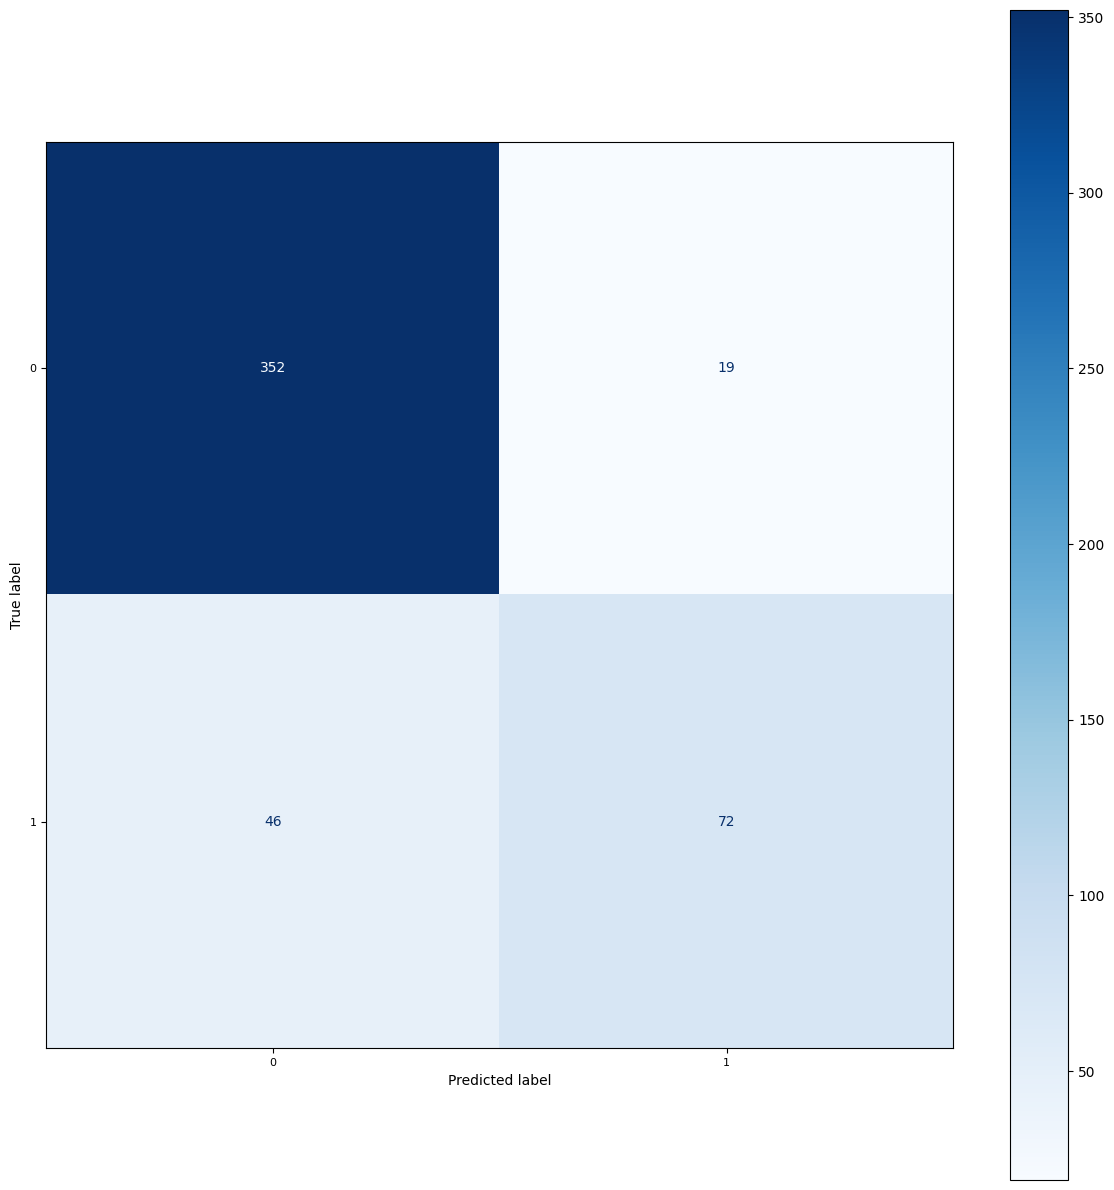

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = [p for p, _ in metrics["predictions"]]
real = [p for _, p in metrics["predictions"]]

class_names = np.unique(real)
cm = confusion_matrix(real, preds, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap="Blues", colorbar=True)

plt.xticks(rotation=0, ha="center", fontsize=8)
plt.yticks(rotation=0, ha="right", fontsize=8)

plt.tight_layout()
plt.show()